<a href="https://colab.research.google.com/github/praivesi/kaggler/blob/main/kaggler_titanic_expert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 시각화
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-whitegrid')
import missingno

#전처리 및 머신러닝 알고리즘
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier

# 모델 튜닝 및 평가
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn import model_selection

# 경고 제거 (Pandas 귀찮은 경고들)
import sys
import warnings 

warnings.filterwarnings('ignore')

<ipython-input-1-393ad3a95d7f>:23: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [2]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


In [3]:
import io
test = pd.read_csv(io.BytesIO(uploaded['test.csv']))
train = pd.read_csv(io.BytesIO(uploaded['train.csv']))

In [4]:
test.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
ntrain = train.shape[0]
ntest = train.shape[0]

y_train = train['Survived'].values
passId = test['PassengerId']

data = pd.concat((train, test))

print('data size is : {}'.format(data.shape))

data size is : (1309, 12)


In [7]:
# 도움되는 EDA용 함수들
train.dtypes
train.columns
train.head()
train.tail()
train.info()
train.describe
train.describe()
train[3:5]
train['Survived'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


0    549
1    342
Name: Survived, dtype: int64

<Axes: >

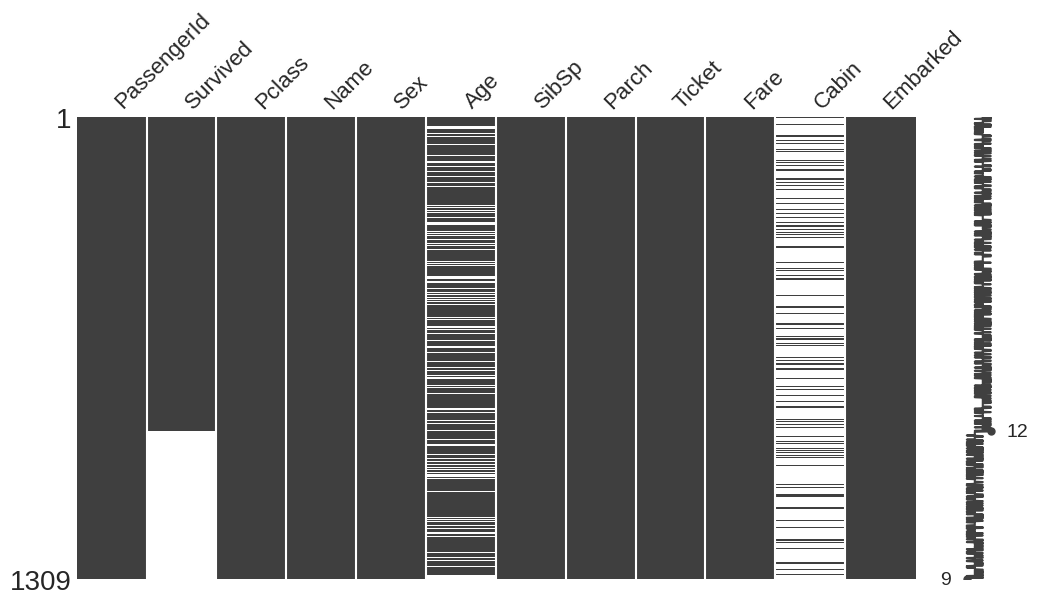

In [8]:
missingno.matrix(data, figsize=(12,6))

In [9]:
data.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [10]:
data.Age.isnull().any()

True

In [11]:
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

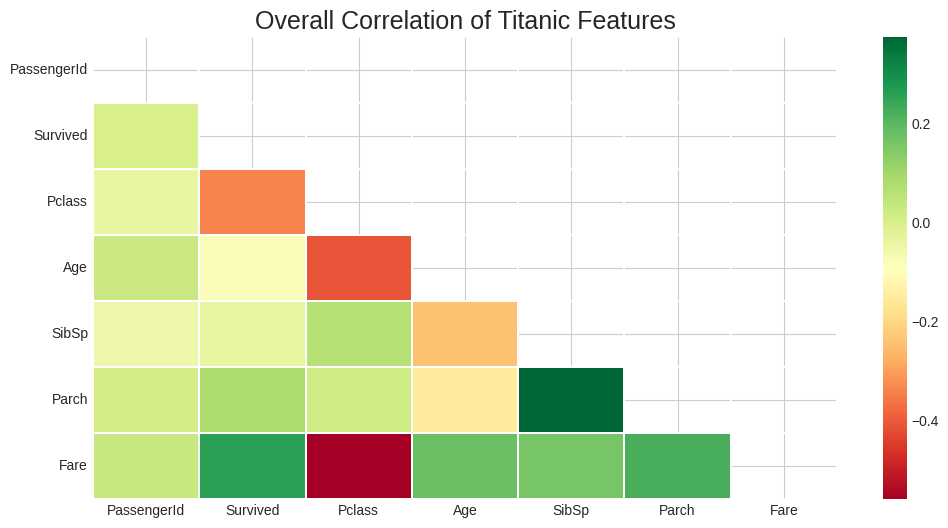

In [12]:
corr = data.corr()
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(12,6))
plt.title('Overall Correlation of Titanic Features', fontsize=18)

sns.heatmap(corr, mask = mask, annot = False, cmap='RdYlGn', linewidths=0.2, annot_kws={'size' : 20})
plt.show()


0    549
1    342
Name: Survived, dtype: int64


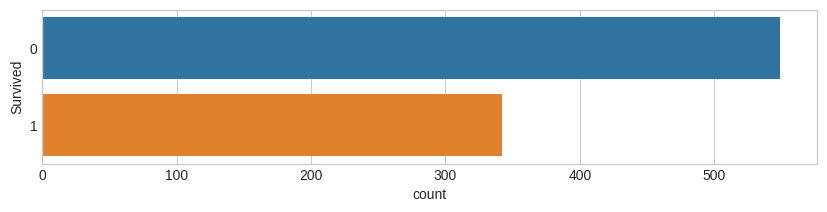

In [13]:
fig = plt.figure(figsize=(10, 2))
sns.countplot(y='Survived', data=train)
print(train.Survived.value_counts())

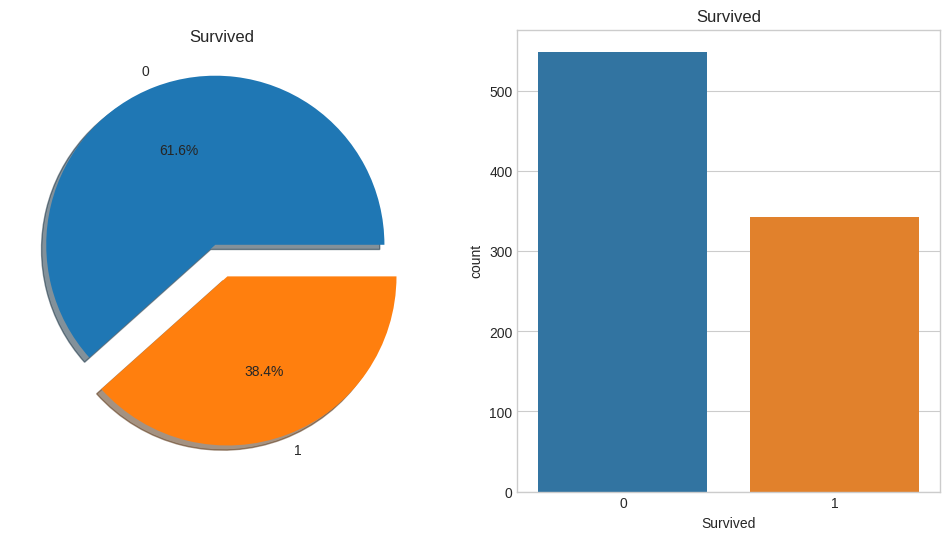

In [14]:
def piecount(col):
  f, ax = plt.subplots(1, 2, figsize=(12,6))
  train[col].value_counts().plot.pie(explode=[0.1 for i in range(train[col].nunique())], autopct='%1.1f%%', ax=ax[0], shadow=True)
  ax[0].set_title(col)
  ax[0].set_ylabel('')
  sns.countplot(x=col, data=train, ax=ax[1])
  ax[1].set_title(col)
  plt.show()

piecount('Survived')

In [15]:
train.groupby(['Pclass', 'Survived'])['Survived'].count()

Pclass  Survived
1       0            80
        1           136
2       0            97
        1            87
3       0           372
        1           119
Name: Survived, dtype: int64

In [16]:
pd.crosstab(train.Pclass, train.Survived, margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


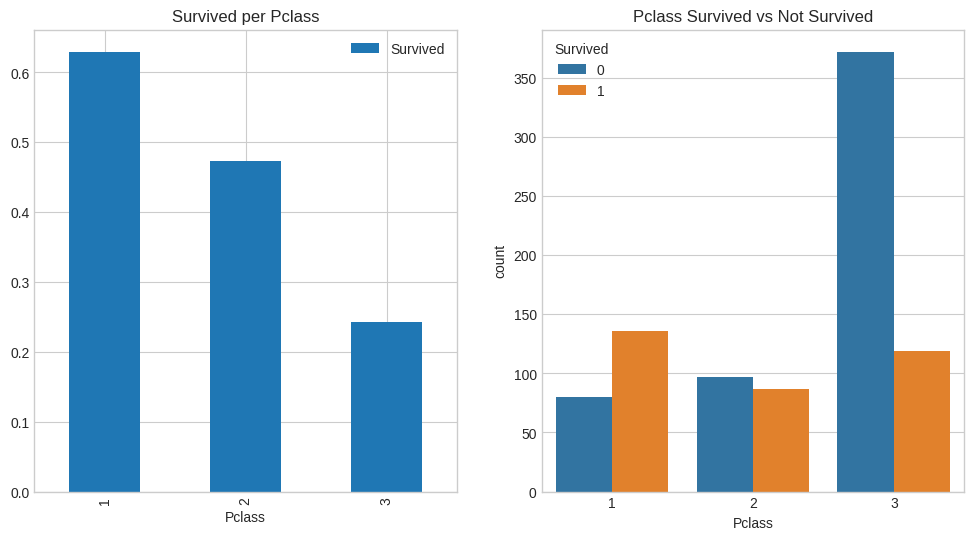

In [17]:
f, ax = plt.subplots(1, 2, figsize=(12,6))
train[['Pclass', 'Survived']].groupby(['Pclass']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived per Pclass')
sns.countplot(x = 'Pclass', hue = 'Survived', data = train, ax = ax[1])
ax[1].set_title('Pclass Survived vs Not Survived')
plt.show()

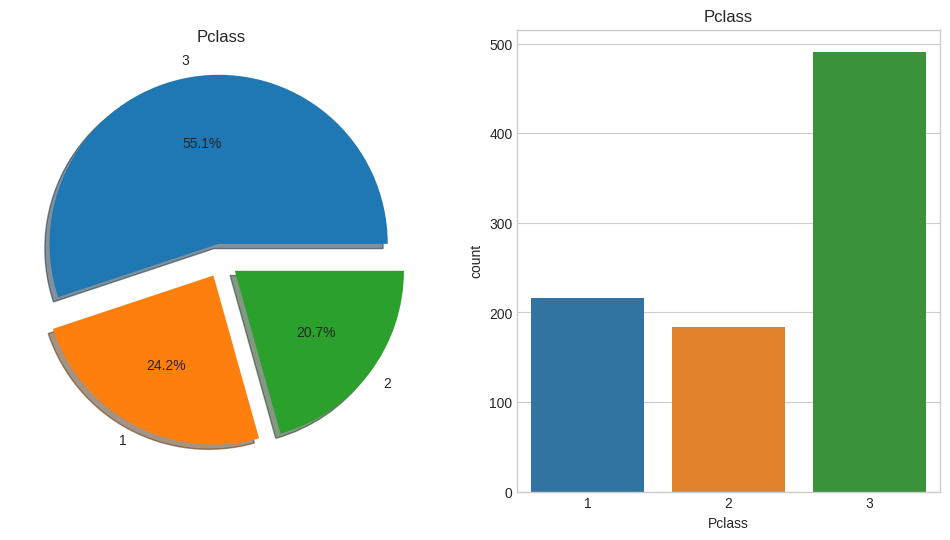

In [18]:
piecount('Pclass')

In [19]:
temp = data.copy()
temp['Initial'] = data.Name.str.extract('([A-Za-z]+)\.')
temp['Initial'].value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Mlle          2
Major         2
Ms            2
Lady          1
Sir           1
Mme           1
Don           1
Capt          1
Countess      1
Jonkheer      1
Dona          1
Name: Initial, dtype: int64

In [20]:
pd.crosstab(temp.Initial, temp.Sex).T.style.background_gradient(cmap='summer_r')

Initial,Capt,Col,Countess,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,1,0,1,0,0,260,2,1,0,197,2,0,0
male,1,4,0,1,0,7,1,0,2,61,0,0,0,757,0,0,8,1


In [21]:
def survpct(col):
  return temp.groupby(col)['Survived'].mean()

survpct('Initial')

Initial
Capt        0.000000
Col         0.500000
Countess    1.000000
Don         0.000000
Dona             NaN
Dr          0.428571
Jonkheer    0.000000
Lady        1.000000
Major       0.500000
Master      0.575000
Miss        0.697802
Mlle        1.000000
Mme         1.000000
Mr          0.156673
Mrs         0.792000
Ms          1.000000
Rev         0.000000
Sir         1.000000
Name: Survived, dtype: float64

In [22]:
# 뭘할진 모르겠지만 일단 이름이 뭔가 생존율의 힌트를 줄 수 있을 것 같으니 Lastname(성) 도 뽑아서 확인해보자.
temp['Lastname'] = data.Name.str.extract('([A-Za-z]+)')
pd.crosstab(temp.Lastname, temp.Survived).T.style.background_gradient(cmap='summer_r')

In [23]:
temp.loc[temp['Initial'] == 'Dona']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Lastname
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9,C105,C,Dona,Oliva


In [24]:
temp.loc[temp['Initial'] == 'Dona', 'Initial'] = 'Mrs'

In [25]:
temp.loc[temp['Initial'] == 'Dona'] # 이젠 없음f

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Lastname


In [26]:
pd.crosstab(temp.Initial, temp.Survived).T.style.background_gradient(cmap='summer_r')

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Survived,,,,,,,,,,,,,,,,,
0.000000,1,1,0,1,4,1,0,1,17,55,0,0,436,26,0,6,0
1.000000,0,1,1,0,3,0,1,1,23,127,2,1,81,99,1,0,1


In [27]:
temp['NumName'] = temp['Lastname'].factorize()[0]

In [28]:
pd.crosstab(temp.NumName, temp.Survived).T.style.background_gradient(cmap='summer_r')

NumName,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651
Survived,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.000000,2,0,0,1,1,2,1,4,3,1,0,0,1,7,1,0,5,4,4,0,1,0,0,0,1,1,2,5,1,1,0,0,1,2,1,0,1,0,1,2,1,1,0,1,1,1,2,6,1,1,0,1,0,0,1,1,6,1,0,2,6,1,0,0,1,1,1,1,1,0,1,1,1,0,0,1,0,0,1,0,1,4,1,1,1,1,1,1,1,1,1,0,0,1,1,2,2,3,4,1,0,0,1,1,2,1,2,2,1,1,1,3,1,1,1,0,0,1,1,1,1,0,1,1,0,1,1,3,0,1,1,1,1,1,1,1,1,1,2,3,0,1,1,7,1,0,1,2,1,0,1,1,4,1,3,1,4,1,1,1,1,0,1,0,3,1,0,1,0,1,0,1,0,1,2,1,1,0,2,0,0,0,2,0,1,1,1,1,0,1,0,0,1,1,1,1,1,0,1,1,2,1,1,1,1,1,1,1,0,1,1,1,1,0,0,2,1,1,2,2,0,0,0,0,0,1,1,1,1,0,1,0,1,0,0,1,0,1,1,1,1,1,2,1,0,1,1,0,0,0,0,1,1,1,1,1,2,0,1,0,1,0,1,1,0,0,0,1,1,2,0,1,0,0,1,1,0,0,1,0,0,1,0,1,0,0,1,1,1,1,0,0,1,1,3,1,1,0,1,0,0,1,2,1,1,0,0,0,0,0,1,1,1,0,1,1,0,0,1,1,2,0,1,0,0,1,1,0,0,1,2,1,1,0,1,1,1,0,1,0,0,1,1,1,1,2,1,0,0,2,0,0,1,0,1,1,1,1,1,0,0,0,0,0,0,2,1,0,1,0,1,0,0,0,2,1,1,1,1,1,1,1,1,2,0,1,1,1,1,0,1,1,0,1,1,1,1,1,1,1,0,1,2,1,1,0,0,0,0,0,0,0,

In [29]:
temp.loc[temp['Lastname'] == 'Ali']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Lastname,NumName
210,211,0.0,3,"Ali, Mr. Ahmed",male,24.0,0,0,SOTON/O.Q. 3101311,7.05,NaN,S,Mr,Ali,182
784,785,0.0,3,"Ali, Mr. William",male,25.0,0,0,SOTON/O.Q. 3101312,7.05,NaN,S,Mr,Ali,182


In [30]:
train[['Sex', 'Survived']].groupby(['Sex']).mean()

,Survived
Sex,
female,0.742038
male,0.188908


In [31]:
def bag(col, target, title, title1):
  f, ax = plt.subplots(1, 2, figsize=(12,6))
  train.groupby([col])[target].mean().plot(kind='bar', ax=ax[0])
  ax[0].set_title(title)
  sns.countplot(x=col, hue=target, data=train, ax=ax[1])
  ax[1].set_title(title1)
  plt.show()

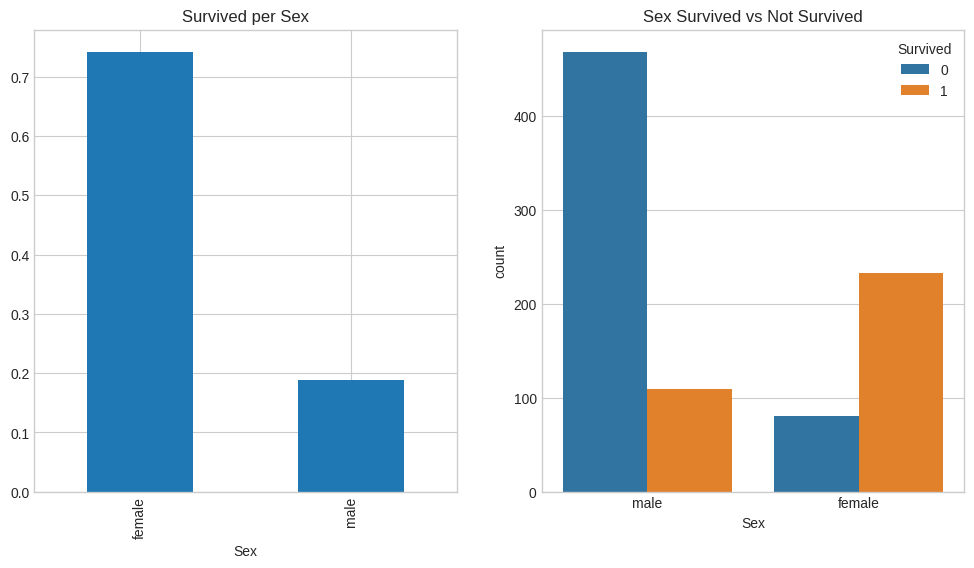

In [32]:
bag('Sex', 'Survived', 'Survived per Sex', 'Sex Survived vs Not Survived')

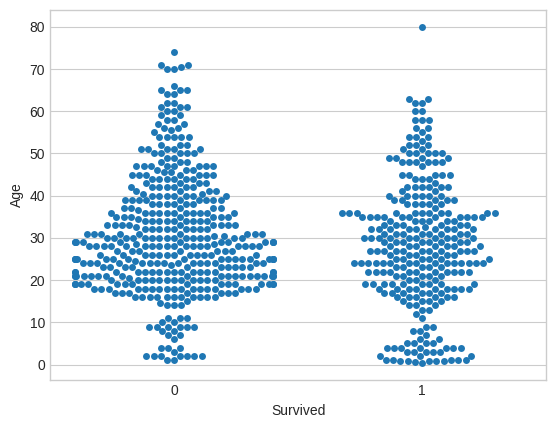

In [33]:
sns.swarmplot(x=train['Survived'], y=train['Age'])
plt.xlabel('Survived')
plt.ylabel('Age')
plt.show()

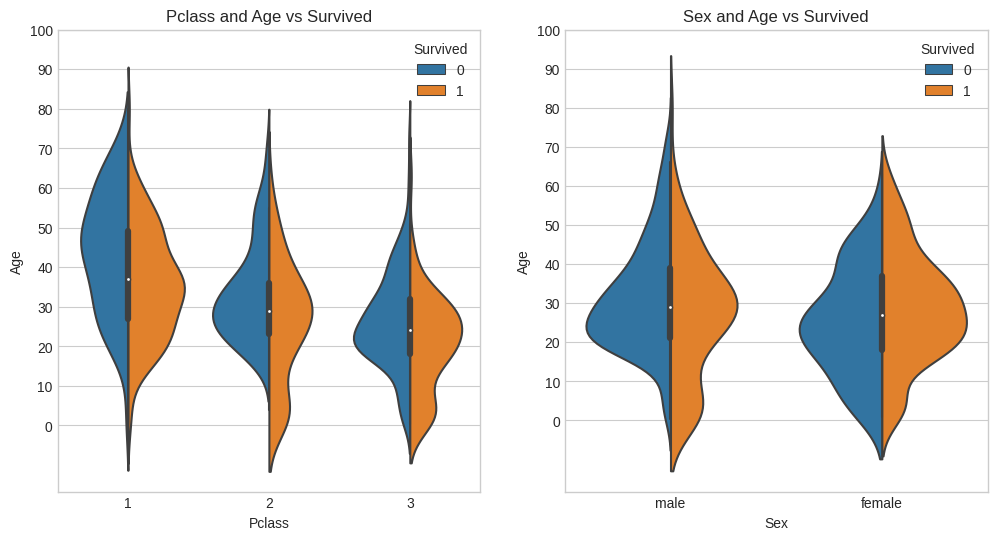

In [34]:
f, ax = plt.subplots(1, 2, figsize=(12,6))
sns.violinplot(x='Pclass', y='Age', hue='Survived', data=train, split=True, ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0, 110, 10))
sns.violinplot(x='Sex', y='Age', hue='Survived', data=train, split=True, ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0, 110, 10))
plt.show()

In [35]:
temp.groupby('Initial').agg({'Age' : ['mean', 'count']}) # 이니셜별 평균 연령 체크

Age      
               mean count
Initial                  
Capt      70.000000     1
Col       54.000000     4
Countess  33.000000     1
Don       40.000000     1
Dr        43.571429     7
Jonkheer  38.000000     1
Lady      48.000000     1
Major     48.500000     2
Master     5.482642    53
Miss      21.774238   210
Mlle      24.000000     2
Mme       24.000000     1
Mr        32.252151   581
Mrs       37.005848   171
Ms        28.000000     1
Rev       41.250000     8
Sir       49.000000     1

In [36]:
# 이니셜별 평균 연령을 결측 Age에 할당
temp = temp.reset_index(drop=True)
temp['Age'] = temp.groupby('Initial')['Age'].apply(lambda x: x.fillna(x.mean()))
temp[31:50]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Lastname,NumName
31,32,1.0,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,37.005848,1,0,PC 17569,146.5208,B78,C,Mrs,Spencer,30
32,33,1.0,3,"Glynn, Miss. Mary Agatha",female,21.774238,0,0,335677,7.7500,NaN,Q,Miss,Glynn,31
33,34,0.0,2,"Wheadon, Mr. Edward H",male,66.000000,0,0,C.A. 24579,10.5000,NaN,S,Mr,Wheadon,32
34,35,0.0,1,"Meyer, Mr. Edgar Joseph",male,28.000000,1,0,PC 17604,82.1708,NaN,C,Mr,Meyer,33
35,36,0.0,1,"Holverson, Mr. Alexander Oskar",male,42.000000,1,0,113789,52.0000,NaN,S,Mr,Holverson,34
36,37,1.0,3,"Mamee, Mr. Hanna",male,32.252151,0,0,2677,7.2292,NaN,C,Mr,Mamee,35
37,38,0.0,3,"Cann, Mr. Ernest Charles",male,21.000000,0,0,A./5. 2152,8.0500,NaN,S,Mr,Cann,36
38,39,0.0,3,"Vander Planke, Miss. Augusta Maria",female,18.000000,2,0,345764,18.0000,NaN,S,Miss,Vander,18
39,40,1.0,3,"Nicola-Yarred, Miss. Jamila",female,14.000000,1,0,2651,11.2417,NaN,C,Miss,Nicola,37
40,41,0.0,3,"Ahlin, Mrs. Johan (Johanna Persdotter Larsson)",female,40.000000,1,0,7546,9.4750,NaN,S,Mrs,Ahlin,38


In [37]:
temp['Initial'].replace(['Capt', 'Col', 'Countess', 'Don', 'Dona' , 'Dr', 'Jonkheer', 'Lady', 'Major', 'Master',  'Miss'  ,'Mlle', 'Mme', 'Mr', 'Mrs', 'Ms', 'Rev', 'Sir'], ['Sacrificed', 'Respected', 'Nobles', 'Mr', 'Mrs', 'Respected', 'Mr', 'Nobles', 'Respected', 'Kids', 'Miss', 'Nobles', 'Nobles', 'Mr', 'Mrs', 'Nobles', 'Sacrificed', 'Nobles'],inplace=True)
temp['Initial'].replace(['Kids', 'Miss', 'Mr', 'Mrs', 'Nobles', 'Respected', 'Sacrificed'], [4, 4, 2, 5, 6, 3, 1], inplace=True)

In [38]:
temp['Age_Range'] = pd.qcut(temp['Age'], 10)

In [39]:
temp['Age_Range'].describe()

count               1309
unique                10
top       (30.0, 32.252]
freq                 225
Name: Age_Range, dtype: object

In [40]:
survpct('Age_Range')

Age_Range
(0.169, 16.0]     0.548077
(16.0, 21.0]      0.307692
(21.0, 23.0]      0.487179
(23.0, 26.0]      0.369863
(26.0, 30.0]      0.400000
(30.0, 32.252]    0.198718
(32.252, 33.0]    0.411765
(33.0, 39.0]      0.504762
(39.0, 48.0]      0.357143
(48.0, 80.0]      0.387500
Name: Survived, dtype: float64

In [41]:
temp['Agroup'] = 0

temp.loc[temp['Age'] < 1.0, 'Agroup'] = 1
temp.loc[(temp['Age'] >=1.0) & (temp['Age'] <= 3.0), 'Agroup'] = 2
temp.loc[(temp['Age'] > 3.0) & (temp['Age'] < 11.0), 'Agroup'] = 7
temp.loc[(temp['Age'] >= 11.0) & (temp['Age'] < 15.0), 'Agroup'] = 13
temp.loc[(temp['Age'] >= 15.0) & (temp['Age'] < 18.0), 'Agroup'] = 16
temp.loc[(temp['Age'] >= 18.0) & (temp['Age'] <=  20.0), 'Agroup'] = 18
temp.loc[(temp['Age'] > 20.0) & (temp['Age'] <= 22.0), 'Agroup'] = 21
temp.loc[(temp['Age'] > 22.0) & (temp['Age'] <= 26.0), 'Agroup'] = 24
temp.loc[(temp['Age'] > 26.0) & (temp['Age'] <= 30.0), 'Agroup'] = 28
temp.loc[(temp['Age'] > 30.0) & (temp['Age'] <= 32.0), 'Agroup'] = 31
temp.loc[(temp['Age'] > 32.0) & (temp['Age'] <= 34.0), 'Agroup'] = 33
temp.loc[(temp['Age'] > 34.0) & (temp['Age'] <= 38.0), 'Agroup'] = 36
temp.loc[(temp['Age'] > 38.0) & (temp['Age'] <= 52.0), 'Agroup'] = 45
temp.loc[(temp['Age'] > 52.0) & (temp['Age'] <= 75.0), 'Agroup'] = 60
temp.loc[temp['Age'] > 75.0, 'Agroup'] = 78

In [42]:
temp.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Lastname,NumName,Age_Range,Agroup
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,Braund,0,"(21.0, 23.0]",21
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,5,Cumings,1,"(33.0, 39.0]",36
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,4,Heikkinen,2,"(23.0, 26.0]",24
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,5,Futrelle,3,"(33.0, 39.0]",36
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,2,Allen,4,"(33.0, 39.0]",36


In [43]:
temp.loc[(temp['Sex'] == 'male'), 'Sex'] = 1
temp.loc[(temp['Sex'] == 'female'), 'Sex'] = 2
temp.loc[(temp['Age'] < 1), 'Sex'] = 3

In [44]:
survpct('Sex')

Sex
1    0.181818
2    0.740385
3    1.000000
Name: Survived, dtype: float64

In [45]:
temp.loc[(temp['SibSp'] == 0) & (temp['Parch'] == 0), 'Alone'] = 1
temp['Family'] = temp['Parch'] + temp['SibSp'] + 1 

In [46]:
temp.head(n=10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Lastname,NumName,Age_Range,Agroup,Alone,Family
0,1,0.0,3,"Braund, Mr. Owen Harris",1,22.000000,1,0,A/5 21171,7.2500,NaN,S,2,Braund,0,"(21.0, 23.0]",21,NaN,2
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",2,38.000000,1,0,PC 17599,71.2833,C85,C,5,Cumings,1,"(33.0, 39.0]",36,NaN,2
2,3,1.0,3,"Heikkinen, Miss. Laina",2,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,4,Heikkinen,2,"(23.0, 26.0]",24,1.0,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",2,35.000000,1,0,113803,53.1000,C123,S,5,Futrelle,3,"(33.0, 39.0]",36,NaN,2
4,5,0.0,3,"Allen, Mr. William Henry",1,35.000000,0,0,373450,8.0500,NaN,S,2,Allen,4,"(33.0, 39.0]",36,1.0,1
5,6,0.0,3,"Moran, Mr. James",1,32.252151,0,0,330877,8.4583,NaN,Q,2,Moran,5,"(30.0, 32.252]",33,1.0,1
6,7,0.0,1,"McCarthy, Mr. Timothy J",1,54.000000,0,0,17463,51.8625,E46,S,2,McCarthy,6,"(48.0, 80.0]",60,1.0,1
7,8,0.0,3,"Palsson, Master. Gosta Leonard",1,2.000000,3,1,349909,21.0750,NaN,S,4,Palsson,7,"(0.169, 16.0]",2,NaN,5
8,9,1.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,27.000000,0,2,347742,11.1333,NaN,S,5,Johnson,8,"(26.0, 30.0]",28,NaN,3
9,10,1.0,2,"Nasser, Mrs. Nicholas (Adele Achem)",2,14.000000,1,0,237736,30.0708,NaN,C,5,Nasser,9,"(0.169, 16.0]",13,NaN,2


In [47]:
survpct('Family')

Family
1     0.303538
2     0.552795
3     0.578431
4     0.724138
5     0.200000
6     0.136364
7     0.333333
8     0.000000
11    0.000000
Name: Survived, dtype: float64

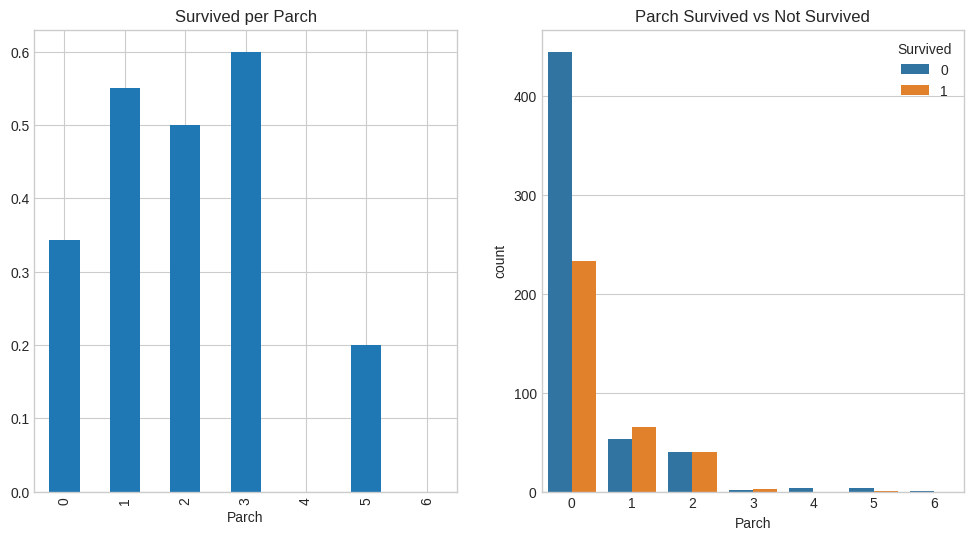

In [48]:
bag('Parch', 'Survived', 'Survived per Parch', 'Parch Survived vs Not Survived')

In [49]:
pd.crosstab([temp.Family, temp.Survived], temp.Pclass, margins=True).style.background_gradient(cmap='summer_r')

In [50]:
temp.Ticket.head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [51]:
temp.Ticket.isnull().any()

False

In [52]:
temp['Initick'] = temp.Ticket.str.extract('^([A-Za-z0-9]+)')
temp = temp.reset_index(drop=True) # 복사한 항목들을 사용하다보면 'ValueError: cannot reindex from a duplicate axis` 요런 에러가 나오는 경우가 많은데 이런 것은 요 코드로 리셋을 한 번 해주면 됩니다.
temp.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Lastname,NumName,Age_Range,Agroup,Alone,Family,Initick
0,1,0.0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,2,Braund,0,"(21.0, 23.0]",21,NaN,2,A
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",2,38.0,1,0,PC 17599,71.2833,C85,C,5,Cumings,1,"(33.0, 39.0]",36,NaN,2,PC
2,3,1.0,3,"Heikkinen, Miss. Laina",2,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,4,Heikkinen,2,"(23.0, 26.0]",24,1.0,1,STON
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",2,35.0,1,0,113803,53.1000,C123,S,5,Futrelle,3,"(33.0, 39.0]",36,NaN,2,113803
4,5,0.0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,2,Allen,4,"(33.0, 39.0]",36,1.0,1,373450


In [53]:
temp['Initick'] = temp.Ticket.str.extract('^([A-Za-z]+)')

In [54]:
temp.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Lastname,NumName,Age_Range,Agroup,Alone,Family,Initick
0,1,0.0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,2,Braund,0,"(21.0, 23.0]",21,NaN,2,A
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",2,38.0,1,0,PC 17599,71.2833,C85,C,5,Cumings,1,"(33.0, 39.0]",36,NaN,2,PC
2,3,1.0,3,"Heikkinen, Miss. Laina",2,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,4,Heikkinen,2,"(23.0, 26.0]",24,1.0,1,STON
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",2,35.0,1,0,113803,53.1000,C123,S,5,Futrelle,3,"(33.0, 39.0]",36,NaN,2,NaN
4,5,0.0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,2,Allen,4,"(33.0, 39.0]",36,1.0,1,NaN


In [55]:
temp['NumTicket'] = temp['Initick'].factorize()[0]

In [56]:
temp.head(15)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked,Initial,Lastname,NumName,Age_Range,Agroup,Alone,Family,Initick,NumTicket
0,1,0.0,3,"Braund, Mr. Owen Harris",1,22.000000,1,0,A/5 21171,7.2500,...,S,2,Braund,0,"(21.0, 23.0]",21,NaN,2,A,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",2,38.000000,1,0,PC 17599,71.2833,...,C,5,Cumings,1,"(33.0, 39.0]",36,NaN,2,PC,1
2,3,1.0,3,"Heikkinen, Miss. Laina",2,26.000000,0,0,STON/O2. 3101282,7.9250,...,S,4,Heikkinen,2,"(23.0, 26.0]",24,1.0,1,STON,2
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",2,35.000000,1,0,113803,53.1000,...,S,5,Futrelle,3,"(33.0, 39.0]",36,NaN,2,NaN,-1
4,5,0.0,3,"Allen, Mr. William Henry",1,35.000000,0,0,373450,8.0500,...,S,2,Allen,4,"(33.0, 39.0]",36,1.0,1,NaN,-1
5,6,0.0,3,"Moran, Mr. James",1,32.252151,0,0,330877,8.4583,...,Q,2,Moran,5,"(30.0, 32.252]",33,1.0,1,NaN,-1
6,7,0.0,1,"McCarthy, Mr. Timothy J",1,54.000000,0,0,17463,51.8625,...,S,2,McCarthy,6,"(48.0, 80.0]",60,1.0,1,NaN,-1
7,8,0.0,3,"Palsson, Master. Gosta Leonard",1,2.000000,3,1,349909,21.0750,...,S,4,Palsson,7,"(0.169, 16.0]",2,NaN,5,NaN,-1
8,9,1.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,27.000000,0,2,347742,11.1333,...,S,5,Johnson,8,"(26.0, 30.0]",28,NaN,3,NaN,-1
9,10,1.0,2,"Nasser, Mrs. Nicholas (Adele Achem)",2,14.000000,1,0,237736,30.0708,...,C,5,Nasser,9,"(0.169, 16.0]",13,NaN,2,NaN,-1


Text(0.5, 1.0, 'Distribution of survived rate for different ticekts')

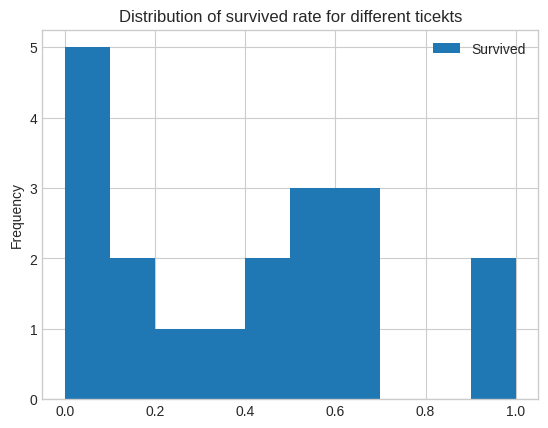

In [57]:
temp.groupby('NumTicket')['Survived'].mean().to_frame().plot(kind='hist')
plt.title('Distribution of survived rate for different ticekts')

In [58]:
temp['Fare'].max()

512.3292

In [59]:
temp['Fare'].min()

0.0

In [60]:
temp['Fare'].mean()

33.29547928134557

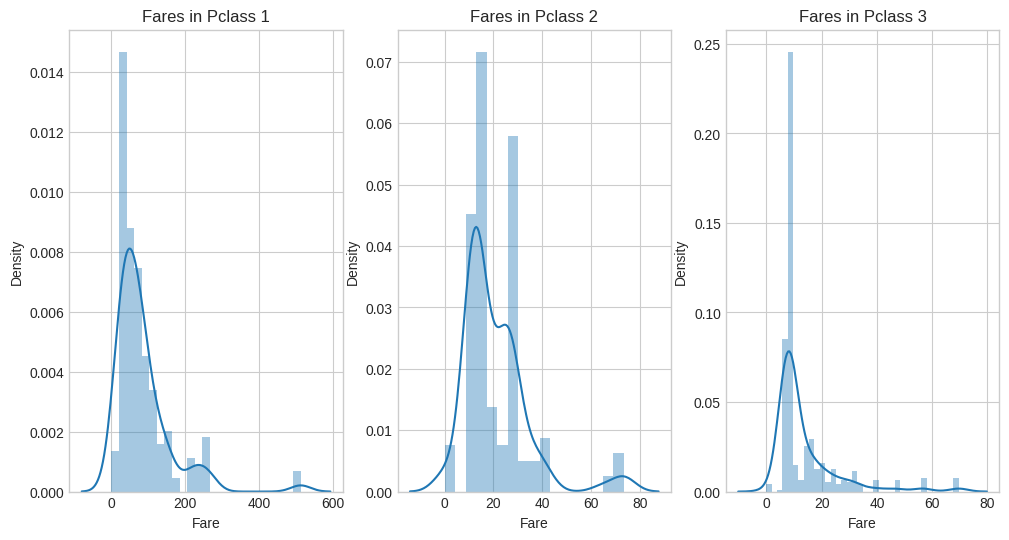

In [61]:
f, ax = plt.subplots(1, 3, figsize=(12,6))
sns.distplot(train[train['Pclass'] == 1].Fare, ax = ax[0])
ax[0].set_title('Fares in Pclass 1')
sns.distplot(train[train['Pclass'] == 2].Fare, ax = ax[1])
ax[1].set_title('Fares in Pclass 2')
sns.distplot(train[train['Pclass'] == 3].Fare, ax = ax[2])
ax[2].set_title('Fares in Pclass 3')
plt.show()

In [62]:
def groupmean(a, b):
  return temp.groupby([a])[b].mean().to_frame().style.background_gradient(cmap='summer_r')

temp['Fare_Range'] = pd.qcut(train['Fare'], 10)
groupmean('Fare_Range', 'Fare')

,Fare
Fare_Range,
"(-0.001, 7.55]",5.928717
"(7.55, 7.854]",7.768490
"(7.854, 8.05]",7.963669
"(8.05, 10.5]",9.521367
"(10.5, 14.454]",12.940231
"(14.454, 21.679]",17.386408
"(21.679, 27.0]",25.487501
"(27.0, 39.688]",32.282186
"(39.688, 77.958]",59.444572


In [63]:
temp['Fgroup'] = 0

temp.loc[temp['Fare'] <= 0,'Fgroup'] = 0
temp.loc[(temp['Fare'] > 0) & (temp['Fare'] <= 7.125), 'Fgroup'] = 1
temp.loc[(temp['Fare'] > 7.125) & (temp['Fare'] <= 7.9), 'Fgroup'] = 2
temp.loc[(temp['Fare'] > 7.9) & (temp['Fare'] <= 8.03), 'Fgroup'] = 3
temp.loc[(temp['Fare'] > 8.03) & (temp['Fare'] < 10.5), 'Fgroup'] = 4
temp.loc[(temp['Fare'] >= 10.5) & (temp['Fare'] < 23.0), 'Fgroup'] = 5
temp.loc[(temp['Fare'] >= 23.0) & (temp['Fare'] <= 27.8), 'Fgroup'] = 6
temp.loc[(temp['Fare'] > 27.8) & (temp['Fare'] <= 51.0), 'Fgroup'] = 7
temp.loc[(temp['Fare'] > 51.0) & (temp['Fare'] <= 73.5), 'Fgroup'] = 8
temp.loc[temp['Fare'] > 73.5, 'Fgroup'] = 9

temp.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Lastname,NumName,Age_Range,Agroup,Alone,Family,Initick,NumTicket,Fare_Range,Fgroup
0,1,0.0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,...,Braund,0,"(21.0, 23.0]",21,NaN,2,A,0,"(-0.001, 7.55]",2
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",2,38.0,1,0,PC 17599,71.2833,...,Cumings,1,"(33.0, 39.0]",36,NaN,2,PC,1,"(39.688, 77.958]",8
2,3,1.0,3,"Heikkinen, Miss. Laina",2,26.0,0,0,STON/O2. 3101282,7.9250,...,Heikkinen,2,"(23.0, 26.0]",24,1.0,1,STON,2,"(7.854, 8.05]",3
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",2,35.0,1,0,113803,53.1000,...,Futrelle,3,"(33.0, 39.0]",36,NaN,2,NaN,-1,"(39.688, 77.958]",8
4,5,0.0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,...,Allen,4,"(33.0, 39.0]",36,1.0,1,NaN,-1,"(7.854, 8.05]",4


In [64]:
temp.Cabin.value_counts().head(10)

C23 C25 C27        6
G6                 5
B57 B59 B63 B66    5
C22 C26            4
F33                4
F2                 4
B96 B98            4
C78                4
F4                 4
D                  4
Name: Cabin, dtype: int64

In [65]:
temp.Cabin.isnull().sum()

1014

In [66]:
temp['Inicab'] = 0
temp['Inicab'] = temp['Cabin'].str.extract('^([A-Za-z]+)')
temp.loc[(temp['Cabin'].isnull()) & (temp['Pclass'].values == 1), 'Inicab'] = 'X'
temp.loc[(temp['Cabin'].isnull()) & (temp['Pclass'].values == 2), 'Inicab'] = 'Y'
temp.loc[(temp['Cabin'].isnull()) & (temp['Pclass'].values == 3), 'Inicab'] = 'Z'

In [67]:
temp['Cabin'].head(20)

0      NaN
1      C85
2      NaN
3     C123
4      NaN
5      NaN
6      E46
7      NaN
8      NaN
9      NaN
10      G6
11    C103
12     NaN
13     NaN
14     NaN
15     NaN
16     NaN
17     NaN
18     NaN
19     NaN
Name: Cabin, dtype: object

In [68]:
temp['Inicab'] = temp['Inicab'].factorize()[0]

In [69]:
temp[11:20]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,NumName,Age_Range,Agroup,Alone,Family,Initick,NumTicket,Fare_Range,Fgroup,Inicab
11,12,1.0,1,"Bonnell, Miss. Elizabeth",2,58.000000,0,0,113783,26.5500,...,11,"(48.0, 80.0]",60,1.0,1,NaN,-1,"(21.679, 27.0]",6,1
12,13,0.0,3,"Saundercock, Mr. William Henry",1,20.000000,0,0,A/5. 2151,8.0500,...,12,"(16.0, 21.0]",18,1.0,1,A,0,"(7.854, 8.05]",4,0
13,14,0.0,3,"Andersson, Mr. Anders Johan",1,39.000000,1,5,347082,31.2750,...,13,"(33.0, 39.0]",45,NaN,7,NaN,-1,"(27.0, 39.688]",7,0
14,15,0.0,3,"Vestrom, Miss. Hulda Amanda Adolfina",2,14.000000,0,0,350406,7.8542,...,14,"(0.169, 16.0]",13,1.0,1,NaN,-1,"(7.55, 7.854]",2,0
15,16,1.0,2,"Hewlett, Mrs. (Mary D Kingcome)",2,55.000000,0,0,248706,16.0000,...,15,"(48.0, 80.0]",60,1.0,1,NaN,-1,"(14.454, 21.679]",5,3
16,17,0.0,3,"Rice, Master. Eugene",1,2.000000,4,1,382652,29.1250,...,16,"(0.169, 16.0]",2,NaN,6,NaN,-1,"(27.0, 39.688]",7,0
17,18,1.0,2,"Williams, Mr. Charles Eugene",1,32.252151,0,0,244373,13.0000,...,17,"(30.0, 32.252]",33,1.0,1,NaN,-1,"(10.5, 14.454]",5,3
18,19,0.0,3,"Vander Planke, Mrs. Julius (Emelia Maria Vande...",2,31.000000,1,0,345763,18.0000,...,18,"(30.0, 32.252]",31,NaN,2,NaN,-1,"(14.454, 21.679]",5,0
19,20,1.0,3,"Masselmani, Mrs. Fatima",2,37.005848,0,0,2649,7.2250,...,19,"(33.0, 39.0]",36,1.0,1,NaN,-1,"(-0.001, 7.55]",2,0


In [70]:
pd.crosstab([temp.Embarked, temp.Pclass], [temp.Sex, temp.Survived], margins=True).style.background_gradient(cmap='summer_r')

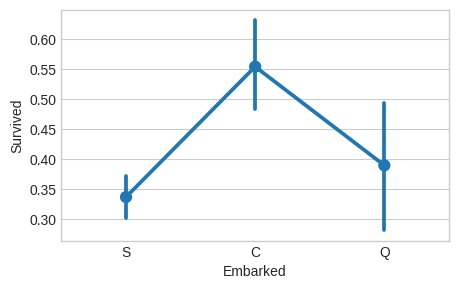

In [71]:
sns.pointplot(x = 'Embarked', y = 'Survived', data=temp)
fig = plt.gcf()
fig.set_size_inches(5, 3)
plt.show()

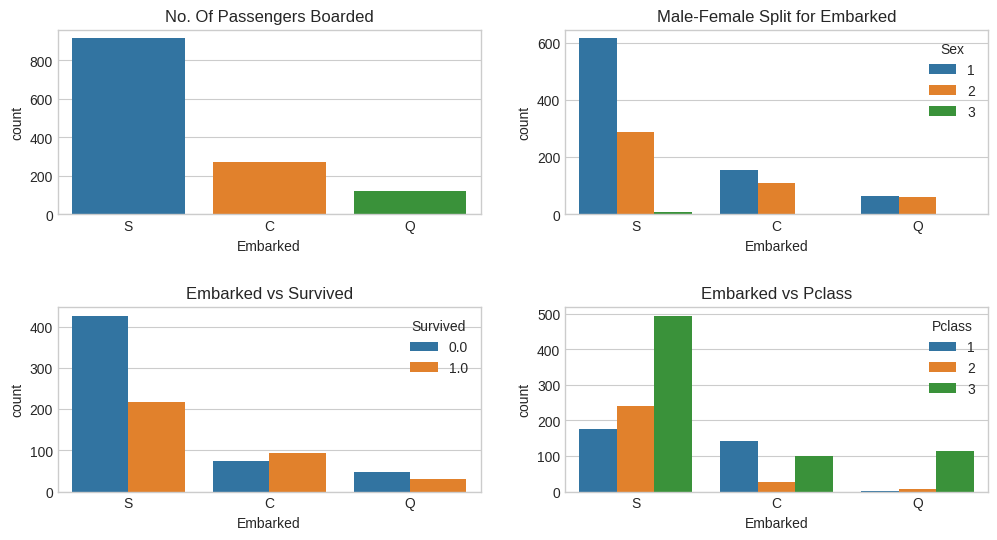

In [72]:
f, ax = plt.subplots(2, 2, figsize=(12, 6))
sns.countplot(x='Embarked', data=temp, ax=ax[0, 0])
ax[0, 0].set_title('No. Of Passengers Boarded')
sns.countplot(x='Embarked', data=temp, hue='Sex', ax=ax[0, 1])
ax[0, 1].set_title('Male-Female Split for Embarked')
sns.countplot(x='Embarked', data=temp, hue='Survived', ax=ax[1, 0])
ax[1, 0].set_title('Embarked vs Survived')
sns.countplot(x='Embarked', data=temp, hue='Pclass', ax=ax[1, 1])
ax[1, 1].set_title('Embarked vs Pclass')

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [73]:
temp.loc[(temp.Embarked.isnull())] # 결측값 찾기

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,NumName,Age_Range,Agroup,Alone,Family,Initick,NumTicket,Fare_Range,Fgroup,Inicab
61,62,1.0,1,"Icard, Miss. Amelie",2,38.0,0,0,113572,80.0,...,58,"(33.0, 39.0]",36,1.0,1,NaN,-1,"(77.958, 512.329]",9,8
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",2,62.0,0,0,113572,80.0,...,616,"(48.0, 80.0]",60,1.0,1,NaN,-1,"(77.958, 512.329]",9,8


In [74]:
temp.loc[temp['Ticket'] == '113572']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,NumName,Age_Range,Agroup,Alone,Family,Initick,NumTicket,Fare_Range,Fgroup,Inicab
61,62,1.0,1,"Icard, Miss. Amelie",2,38.0,0,0,113572,80.0,...,58,"(33.0, 39.0]",36,1.0,1,NaN,-1,"(77.958, 512.329]",9,8
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",2,62.0,0,0,113572,80.0,...,616,"(48.0, 80.0]",60,1.0,1,NaN,-1,"(77.958, 512.329]",9,8


In [75]:
temp.sort_values(['Ticket'], ascending=True)[['Ticket', 'Embarked']][55:70]

,Ticket,Embarked
54,113509,C
351,113510,S
252,113514,S
829,113572,NaN
61,113572,NaN
802,113760,S
390,113760,S
435,113760,S
763,113760,S
185,113767,S


In [76]:
temp.loc[temp['Ticket'] == '113572', 'Embarked'] = 'S'

In [77]:
temp.sort_values(['Ticket'], ascending=True)[['Ticket', 'Embarked']][55:70]

,Ticket,Embarked
54,113509,C
351,113510,S
252,113514,S
829,113572,S
61,113572,S
802,113760,S
390,113760,S
435,113760,S
763,113760,S
185,113767,S


In [78]:
temp.loc[temp.Embarked.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,NumName,Age_Range,Agroup,Alone,Family,Initick,NumTicket,Fare_Range,Fgroup,Inicab


In [79]:
temp['Embarked'] = temp['Embarked'].factorize()[0]
temp.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,NumName,Age_Range,Agroup,Alone,Family,Initick,NumTicket,Fare_Range,Fgroup,Inicab
0,1,0.0,3,"Braund, Mr. Owen Harris",1,22.000000,1,0,A/5 21171,7.2500,...,0,"(21.0, 23.0]",21,NaN,2,A,0,"(-0.001, 7.55]",2,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",2,38.000000,1,0,PC 17599,71.2833,...,1,"(33.0, 39.0]",36,NaN,2,PC,1,"(39.688, 77.958]",8,1
2,3,1.0,3,"Heikkinen, Miss. Laina",2,26.000000,0,0,STON/O2. 3101282,7.9250,...,2,"(23.0, 26.0]",24,1.0,1,STON,2,"(7.854, 8.05]",3,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",2,35.000000,1,0,113803,53.1000,...,3,"(33.0, 39.0]",36,NaN,2,NaN,-1,"(39.688, 77.958]",8,1
4,5,0.0,3,"Allen, Mr. William Henry",1,35.000000,0,0,373450,8.0500,...,4,"(33.0, 39.0]",36,1.0,1,NaN,-1,"(7.854, 8.05]",4,0
5,6,0.0,3,"Moran, Mr. James",1,32.252151,0,0,330877,8.4583,...,5,"(30.0, 32.252]",33,1.0,1,NaN,-1,"(8.05, 10.5]",4,0
6,7,0.0,1,"McCarthy, Mr. Timothy J",1,54.000000,0,0,17463,51.8625,...,6,"(48.0, 80.0]",60,1.0,1,NaN,-1,"(39.688, 77.958]",8,2
7,8,0.0,3,"Palsson, Master. Gosta Leonard",1,2.000000,3,1,349909,21.0750,...,7,"(0.169, 16.0]",2,NaN,5,NaN,-1,"(14.454, 21.679]",5,0
8,9,1.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,27.000000,0,2,347742,11.1333,...,8,"(26.0, 30.0]",28,NaN,3,NaN,-1,"(10.5, 14.454]",5,0
9,10,1.0,2,"Nasser, Mrs. Nicholas (Adele Achem)",2,14.000000,1,0,237736,30.0708,...,9,"(0.169, 16.0]",13,NaN,2,NaN,-1,"(27.0, 39.688]",7,3


In [80]:
temp[11:20]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,NumName,Age_Range,Agroup,Alone,Family,Initick,NumTicket,Fare_Range,Fgroup,Inicab
11,12,1.0,1,"Bonnell, Miss. Elizabeth",2,58.000000,0,0,113783,26.5500,...,11,"(48.0, 80.0]",60,1.0,1,NaN,-1,"(21.679, 27.0]",6,1
12,13,0.0,3,"Saundercock, Mr. William Henry",1,20.000000,0,0,A/5. 2151,8.0500,...,12,"(16.0, 21.0]",18,1.0,1,A,0,"(7.854, 8.05]",4,0
13,14,0.0,3,"Andersson, Mr. Anders Johan",1,39.000000,1,5,347082,31.2750,...,13,"(33.0, 39.0]",45,NaN,7,NaN,-1,"(27.0, 39.688]",7,0
14,15,0.0,3,"Vestrom, Miss. Hulda Amanda Adolfina",2,14.000000,0,0,350406,7.8542,...,14,"(0.169, 16.0]",13,1.0,1,NaN,-1,"(7.55, 7.854]",2,0
15,16,1.0,2,"Hewlett, Mrs. (Mary D Kingcome)",2,55.000000,0,0,248706,16.0000,...,15,"(48.0, 80.0]",60,1.0,1,NaN,-1,"(14.454, 21.679]",5,3
16,17,0.0,3,"Rice, Master. Eugene",1,2.000000,4,1,382652,29.1250,...,16,"(0.169, 16.0]",2,NaN,6,NaN,-1,"(27.0, 39.688]",7,0
17,18,1.0,2,"Williams, Mr. Charles Eugene",1,32.252151,0,0,244373,13.0000,...,17,"(30.0, 32.252]",33,1.0,1,NaN,-1,"(10.5, 14.454]",5,3
18,19,0.0,3,"Vander Planke, Mrs. Julius (Emelia Maria Vande...",2,31.000000,1,0,345763,18.0000,...,18,"(30.0, 32.252]",31,NaN,2,NaN,-1,"(14.454, 21.679]",5,0
19,20,1.0,3,"Masselmani, Mrs. Fatima",2,37.005848,0,0,2649,7.2250,...,19,"(33.0, 39.0]",36,1.0,1,NaN,-1,"(-0.001, 7.55]",2,0


In [81]:
temp['Embarked'][11:20]

11    0
12    0
13    0
14    0
15    0
16    2
17    0
18    0
19    1
Name: Embarked, dtype: int64

In [82]:
survpct('Initial')

Initial
1    0.000000
2    0.156069
3    0.454545
4    0.675676
5    0.792000
6    1.000000
Name: Survived, dtype: float64

In [83]:
survpct('Pclass')

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

In [84]:
survpct('Sex')

Sex
1    0.181818
2    0.740385
3    1.000000
Name: Survived, dtype: float64

In [85]:
survpct('Age').head()

Age
0.17    NaN
0.33    NaN
0.42    1.0
0.67    1.0
0.75    1.0
Name: Survived, dtype: float64

In [86]:
survpct('Fgroup')

Fgroup
0    0.066667
1    0.037037
2    0.232044
3    0.473684
4    0.144330
5    0.425000
6    0.489362
7    0.353535
8    0.564516
9    0.762887
Name: Survived, dtype: float64

In [89]:
temp['Priority'] = 0
temp.loc[temp['Initial'] == 6, 'Priority'] = 1
temp.loc[(temp['Pclass'] == 1) & (temp['Sex'] == 2), 'Priority'] = 2
temp.loc[temp['Age'] < 1, 'Priority'] = 3
temp.loc[(temp['Pclass'] == 1) & (temp['Age'] <= 17), 'Priority'] = 4
temp.loc[(temp['Pclass'] == 2) & (temp['Age'] <= 17), 'Priority'] = 5
temp.loc[(temp['Pclass'] == 2) & (temp['Sex'] == 2), 'Priority'] = 6
temp.loc[(temp['Fgroup'] == 9), 'Priority'] = 7

In [90]:
survpct('Priority')

Priority
0    0.229508
1    1.000000
2    0.965517
3    1.000000
4    1.000000
5    0.818182
6    0.921053
7    0.762887
Name: Survived, dtype: float64

In [91]:
temp.Priority.value_counts()

0    978
7    145
6    105
2     52
5     16
3      7
4      4
1      2
Name: Priority, dtype: int64

In [92]:
survpct('Family')

Family
1     0.303538
2     0.552795
3     0.578431
4     0.724138
5     0.200000
6     0.136364
7     0.333333
8     0.000000
11    0.000000
Name: Survived, dtype: float64

In [93]:
survpct('Fgroup')

Fgroup
0    0.066667
1    0.037037
2    0.232044
3    0.473684
4    0.144330
5    0.425000
6    0.489362
7    0.353535
8    0.564516
9    0.762887
Name: Survived, dtype: float64

In [94]:
temp['FH'] = 0
temp.loc[(temp['Sex'] == 1), 'FH'] = 0
temp.loc[(temp['Sex'] == 2), 'FH'] = 1
temp.loc[(temp['Sex'] == 2) & (temp['Family'] == 2), 'FH'] = 2
temp.loc[(temp['Sex'] == 2) & (temp['Family'] == 3), 'FH'] = 3
temp.loc[(temp['Sex'] == 2) & (temp['Family'] == 4), 'FH'] = 4
temp.loc[(temp['Sex'] == 2) & (temp['Family'] == 1) & (temp['Pclass'] == 1), 'FH'] = 5
temp.loc[(temp['Sex'] == 2) & (temp['Family'] == 1) & (temp['Pclass'] == 2), 'FH'] = 6
temp.loc[(temp['Sex'] == 2) & (temp['Fgroup'] == 3), 'FH'] = 7
temp.loc[(temp['Sex'] == 2) & (temp['Fgroup'] >= 5), 'FH'] = 8

In [95]:
temp['MH'] = 0
temp.loc[(temp['Sex'] == 2), 'MH'] = 0
temp.loc[(temp['Sex'] == 1), 'MH'] = 1
temp.loc[(temp['Sex'] == 1) & (temp['Family'] == 2), 'MH'] = 2
temp.loc[(temp['Sex'] == 1) & (temp['Family'] == 3), 'MH'] = 3
temp.loc[(temp['Sex'] == 1) & (temp['Family'] == 4), 'MH'] = 4
temp.loc[(temp['Sex'] == 1) & (temp['Family'] == 1) & (temp['Pclass'] == 1), 'MH'] = 5
temp.loc[(temp['Sex'] == 1) & (temp['Family'] == 1) & (temp['Pclass'] == 2), 'MH'] = 6
temp.loc[(temp['Sex'] == 1) & (temp['Fgroup'] == 3), 'MH'] = 7
temp.loc[(temp['Sex'] == 1) & (temp['Fgroup'] >= 5), 'MH'] = 8

In [96]:
temp['FL'] = 0
temp.loc[(temp['Sex'] == 1), 'FL'] = 0
temp.loc[(temp['Sex'] == 2) & (temp['Fgroup'] < 5), 'FL'] = 1
temp.loc[(temp['Sex'] == 2) & (temp['Fgroup'] != 3), 'FL'] = 2
temp.loc[(temp['Sex'] == 2) & (temp['FH'] == 1), 'FL'] = 3
temp.loc[(temp['Sex'] == 2) & (temp['Family'] < 2), 'FL'] = 4
temp.loc[(temp['Sex'] == 2) & (temp['Family'] > 4), 'FL'] = 5
temp.loc[(temp['Sex'] == 2) & (temp['Family'] == 1) & (temp['Pclass'] == 3), 'FL'] = 6

In [97]:
temp['ML'] = 0
temp.loc[(temp['Sex'] == 2), 'ML'] = 0
temp.loc[(temp['Sex'] == 1) & (temp['Fgroup'] < 5), 'ML'] = 1
temp.loc[(temp['Sex'] == 1) & (temp['Fgroup'] != 3), 'ML'] = 2
temp.loc[(temp['Sex'] == 1) & (temp['MH'] <7), 'ML'] = 3
temp.loc[(temp['Sex'] == 1) & (temp['Family'] < 2), 'ML'] = 4
temp.loc[(temp['Sex'] == 1) & (temp['Family'] > 4), 'ML'] = 5
temp.loc[(temp['Sex'] == 1) & (temp['Family'] == 1) & (temp['Pclass'] == 3), 'ML'] = 6

In [98]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [99]:
temp['F1'] = temp['Priority']
temp['F2'] = temp['FH']
temp['F3'] = temp['MH']
temp['F4'] = temp['FL']
temp['F5'] = temp['ML']
temp['F6'] = temp['Initial']
temp['F7'] = temp['Fgroup']
temp['F8'] = temp['NumName']
temp['F9'] = temp['NumTicket']
temp['F10'] = temp['Family']
temp['F11'] = temp['Embarked']
temp['F12'] = temp['Sex']
temp['F13'] = temp['Pclass']

In [100]:
dfl = pd.DataFrame()
good_columns = ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'F13']
dfl[good_columns] = temp[good_columns ]

In [101]:
dfl.head() 

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13
0,0,0,2,0,3,2,2,0,0,2,0,1,3
1,2,8,0,2,0,5,8,1,1,2,1,2,1
2,0,7,0,6,0,4,3,2,2,1,0,2,3
3,2,8,0,2,0,5,8,3,-1,2,0,2,1
4,0,0,1,0,6,2,4,4,-1,1,0,1,3


In [102]:
dfh = dfl.copy()


In [103]:
dfl_enc = dfl.apply(LabelEncoder().fit_transform)
dfl_enc.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13
0,0,0,2,0,3,1,2,0,1,1,0,0,2
1,2,5,0,2,0,4,8,1,2,1,1,1,0
2,0,4,0,5,0,3,3,2,3,0,0,1,2
3,2,5,0,2,0,4,8,3,0,1,0,1,0
4,0,0,1,0,6,1,4,4,0,0,0,0,2


In [104]:
one_hot_cols = dfh.columns.tolist()
dfh_enc = pd.get_dummies(dfh, columns=one_hot_cols)

dfh_enc.head()

,F1_0,F1_1,F1_2,F1_3,F1_4,F1_5,F1_6,F1_7,F2_0,F2_1,...,F10_11,F11_0,F11_1,F11_2,F12_1,F12_2,F12_3,F13_1,F13_2,F13_3
0,1,0,0,0,0,0,0,0,1,0,...,0,1,0,0,1,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
3,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0
4,1,0,0,0,0,0,0,0,1,0,...,0,1,0,0,1,0,0,0,0,1


In [105]:
train = dfh_enc[:ntrain]
test = dfh_enc[ntrain:]

In [106]:
X_train = train
X_test = test

In [107]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [108]:
ran = RandomForestClassifier(random_state=1)
knn = KNeighborsClassifier()
log = LogisticRegression()
xgb = XGBClassifier()
gbc = GradientBoostingClassifier()
svc = SVC(probability=True)
ext = ExtraTreesClassifier()
ada = AdaBoostClassifier()
gnb = GaussianNB()
gpc = GaussianProcessClassifier()
bag = BaggingClassifier()

In [109]:
 # 리스트 준비
models = [ran, knn, log, xgb, gbc, svc, ext, ada, gnb, gpc, bag]         
model_names = ['Random Forest', 'K Nearest Neighbour', 'Logistic Regression', 'XGBoost', 'Gradient Boosting', 'SVC', 'Extra Trees', 'AdaBoost', 'Gaussian Naive Bayes', 'Gaussian Process', 'Bagging Classifier']
scores = {}

In [110]:
for ind, mod in enumerate(models):
  mod.fit(X_train, y_train)
  acc = cross_val_score(mod, X_train, y_train, scoring = 'accuracy', cv = 10)
  scores[model_names[ind]] = acc


In [111]:
results = pd.DataFrame(scores).T
results['mean'] = results.mean(1)

result_df = results.sort_values(by='mean', ascending=False)
result_df.head(11)

,0,1,2,3,4,5,6,7,8,9,mean
Bagging Classifier,0.800000,0.865169,0.775281,0.898876,0.898876,0.842697,0.842697,0.764045,0.842697,0.853933,0.838427
SVC,0.833333,0.887640,0.797753,0.876404,0.865169,0.797753,0.808989,0.764045,0.865169,0.820225,0.831648
Extra Trees,0.766667,0.865169,0.741573,0.887640,0.876404,0.853933,0.842697,0.764045,0.853933,0.853933,0.830599
Random Forest,0.777778,0.876404,0.752809,0.887640,0.887640,0.842697,0.831461,0.775281,0.853933,0.820225,0.830587
Gradient Boosting,0.822222,0.831461,0.775281,0.876404,0.865169,0.820225,0.842697,0.797753,0.831461,0.842697,0.830537
Logistic Regression,0.800000,0.853933,0.797753,0.865169,0.876404,0.808989,0.820225,0.786517,0.853933,0.820225,0.828315
AdaBoost,0.811111,0.831461,0.786517,0.865169,0.853933,0.808989,0.808989,0.797753,0.820225,0.842697,0.822684
XGBoost,0.755556,0.831461,0.719101,0.887640,0.853933,0.842697,0.820225,0.775281,0.853933,0.831461,0.817129
K Nearest Neighbour,0.788889,0.820225,0.786517,0.797753,0.842697,0.786517,0.786517,0.730337,0.842697,0.831461,0.801361
Gaussian Process,0.522222,0.696629,0.539326,0.494382,0.573034,0.528090,0.426966,0.561798,0.550562,0.606742,0.549975


Text(0.5, 0, 'Accuracy Score (%)')

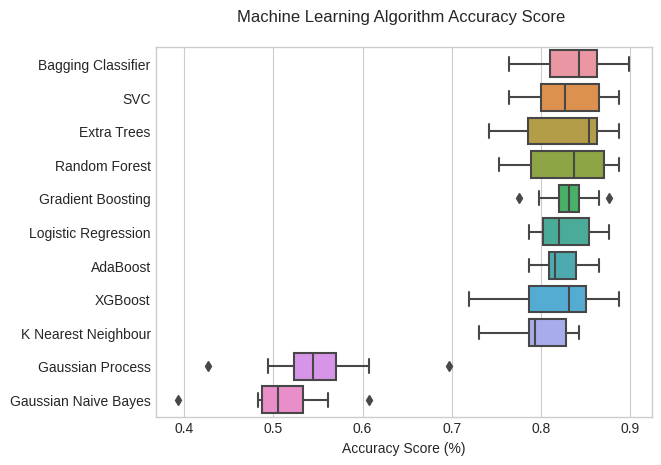

In [112]:
result_df = result_df.drop(['mean'], axis=1)
sns.boxplot(data=result_df.T, orient='h')
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')

In [113]:
# 중요도를 보는 함수를 만듭니다.
def importance_plotting(data, xlabel, ylabel, title, n=20):
  sns.set(style='whitegrid')
  ax = data.tail(n).plot(kind='barh')

  ax.set(title=title, xlabel=xlabel, ylabel=ylabel)
  ax.xaxis.grid(False)
  ax.yaxis.grid(True)
  plt.show()

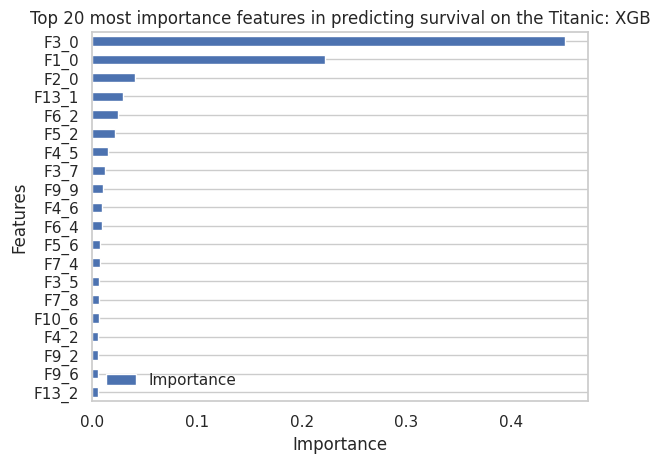

In [114]:
# 데이터 프레임에 항목 중요도를 넣습니다.
fi = {'Features': train.columns.tolist(), 'Importance': xgb.feature_importances_}
importance = pd.DataFrame(fi, index=fi['Features']).sort_values('Importance', ascending=True)

title = 'Top 20 most importance features in predicting survival on the Titanic: XGB'

importance_plotting(importance, 'Importance', 'Features', title, 20)

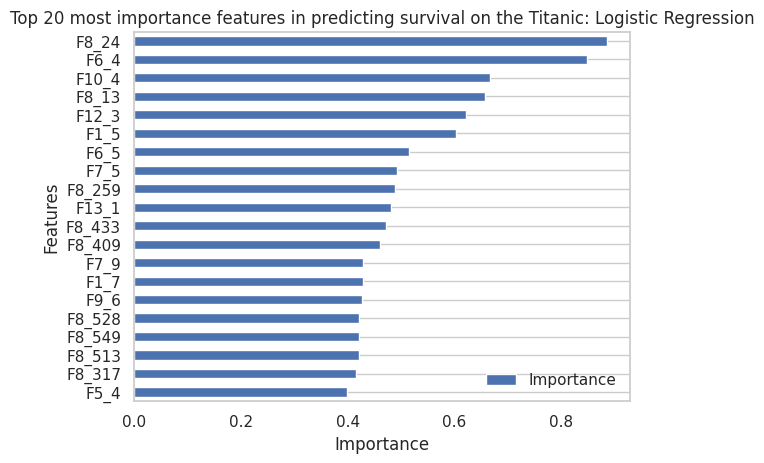

In [115]:
# 중요도를 데이터프레임에 넣습니다. Logistic regression에서는 중요도보다 coefficients를 사용합니다. 
# 아래는 Features라는 열에 트레인의 열들의 이름을 리스트로 만들어서 넣고 Importance에는 Logistic regression에는 coefficient를 바꾸어 넣어라는 넘파이 명령입니다.(즉 가로를 세로로)
fi = {'Features': train.columns.tolist(), 'Importance': np.transpose(log.coef_[0])}
importance = pd.DataFrame(fi, index=fi['Features']).sort_values('Importance', ascending=True)

title = 'Top 20 most importance features in predicting survival on the Titanic: Logistic Regression'

importance_plotting(importance, 'Importance', 'Features', title, 20)

In [116]:
# 5가지 모델에 대한 항목 중요도 얻기
gbc_imp = pd.DataFrame({'Feature':train.columns, 'gbc importance':gbc.feature_importances_})
xgb_imp = pd.DataFrame({'Feature':train.columns, 'xgb importance':xgb.feature_importances_})
ran_imp = pd.DataFrame({'Feature':train.columns, 'ran importance':ran.feature_importances_})
ext_imp = pd.DataFrame({'Feature':train.columns, 'ext importance':ext.feature_importances_})
ada_imp = pd.DataFrame({'Feature':train.columns, 'ada importance':ada.feature_importances_})

# 이를 하나의 데이터프레임으로
importances = gbc_imp.merge(xgb_imp, on='Feature').merge(ran_imp, on='Feature').merge(ext_imp, on='Feature').merge(ada_imp, on='Feature')

# 항목당 평균 중요도
importances['Average'] = importances.mean(axis=1)

# 랭킹 정하기
importances = importances.sort_values(by='Average', ascending=False).reset_index(drop=True)

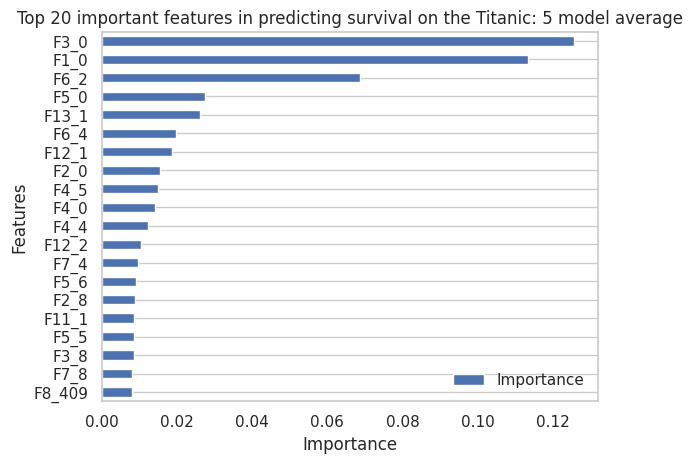

In [117]:
# 중요도를 다시 데이터 프레임에 넣기
fi = {'Features': importances['Feature'], 'Importance': importances['Average']}
importance = pd.DataFrame(fi).set_index('Features').sort_values('Importance', ascending=True)

# 그래프 타이틀
title = 'Top 20 important features in predicting survival on the Titanic: 5 model average'

# 그래프 보기
importance_plotting(importance, 'Importance', 'Features', title, 20)

In [118]:
importance1 = importance[-381:]
importance1[371:381]

,Importance
Features,
F4_0,0.014178
F4_5,0.015089
F2_0,0.015610
F12_1,0.018819
F6_4,0.019761
F13_1,0.026269
F5_0,0.027349
F6_2,0.068764
F1_0,0.113339


In [119]:
# 영양가 있는 380개만 넣기 - 380개는 휴리스틱으로 노가다하면서 구한 값임
mylist = list(importance1.index)

In [120]:
train1 = pd.DataFrame()
test1 = pd.DataFrame()

for i in mylist:
  train1[i] = train[i]
  test1[i] = test[i]

train1.head()

,F8_103,F1_4,F8_626,F8_611,F8_545,F8_6,F8_625,F8_90,F3_3,F8_19,...,F4_0,F4_5,F2_0,F12_1,F6_4,F13_1,F5_0,F6_2,F1_0,F3_0
0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,0,0,1,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,1,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,0,0,1,1,0


In [121]:
train = train1
test = test1

# 모델의 변수를 다시 정의하고
X_train = train
X_test = test

# 바꿉니다.
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

ran = RandomForestClassifier(random_state=1)
knn = KNeighborsClassifier()
log = LogisticRegression()
xgb = XGBClassifier(random_state=1)
gbc = GradientBoostingClassifier(random_state=1)
svc = SVC(probability=True)
ext = ExtraTreesClassifier(random_state=1)
ada = AdaBoostClassifier(random_state=1)
gnb = GaussianNB()
gpc = GaussianProcessClassifier()
bag = BaggingClassifier(random_state=1)

# 리스트 준비
models = [ran, knn, log, xgb, gbc, svc, ext, ada, gnb, gpc, bag]         
model_names = ['Random Forest', 'K Nearest Neighbour', 'Logistic Regression', 'XGBoost', 'Gradient Boosting', 'SVC', 'Extra Trees', 'AdaBoost', 'Gaussian Naive Bayes', 'Gaussian Process', 'Bagging Classifier']
scores2 = {}

# 학습 및 교차 검증
for ind, mod in enumerate(models):
    mod.fit(X_train, y_train)
    acc = cross_val_score(mod, X_train, y_train, scoring = "accuracy", cv = 10)
    scores2[model_names[ind]] = acc

Random Forest           0.835081
Logistic Regression     0.833908
Bagging Classifier      0.832759
Gradient Boosting       0.830549
Extra Trees             0.829463
AdaBoost                0.823808
XGBoost                 0.819376
Gaussian Process        0.794619
SVC                     0.792422
K Nearest Neighbour     0.792422
Gaussian Naive Bayes    0.764332
Name: mean, dtype: float64


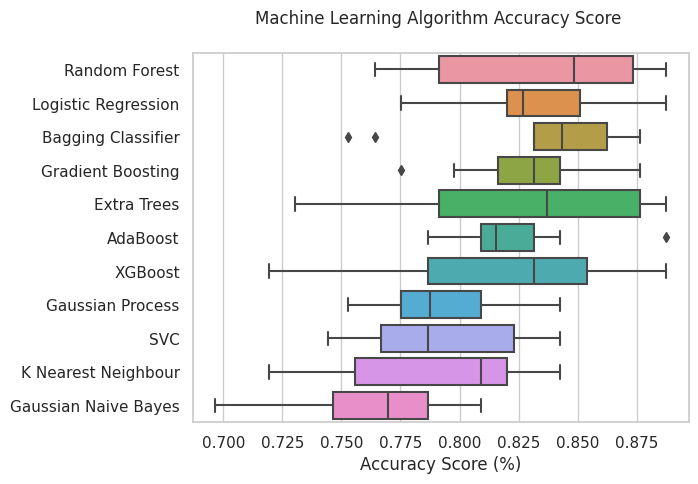

In [122]:
# 결과 테이블을 만듭니다.
results = pd.DataFrame(scores2).T
results['mean'] = results.mean(1)

result_df = results.sort_values(by='mean', ascending=False)#.reset_index()
print(result_df.sort_values('mean', ascending=False)['mean'].head(11))

result_df = result_df.drop(['mean'], axis=1)
sns.boxplot(data=result_df.T, orient='h')
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)');

In [123]:
 ## SVC
 
 # 파라미터 서치
Cs = [0.01, 0.1, 1, 5, 10, 15, 20, 50]
gammas = [0.001, 0.01, 0.1]

# 파라미터 그리드 세팅
hyperparams = {'C' : Cs, 'gamma': gammas}

# 교차검증
gd = GridSearchCV(estimator = SVC(probability=True), param_grid = hyperparams, verbose=True, cv=5, scoring="accuracy", n_jobs=-1)

gd.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


AttributeError: ignored

In [124]:
print(gd.best_score_)
print(gd.best_params_)

0.8383654510074697
{'C': 10, 'gamma': 0.001}


In [125]:
## Gradient Boosting Classifier

learning_rate = [0.01, 0.05, 0.1, 0.2, 0.5]
n_estimators = [100, 1000, 2000]
max_depth = [3, 5, 10, 15]

hyperparams = {'learning_rate': learning_rate, 'n_estimators': n_estimators}

gd=GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy", n_jobs=-1)

gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
0.8395016006528152
{'learning_rate': 0.05, 'n_estimators': 2000}


In [126]:
## Logisitic Regression

penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)

hyperparams = {'penalty': penalty, 'C': C}

gd=GridSearchCV(estimator = LogisticRegression(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy", n_jobs=-1)

gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
0.8294206264515724
{'C': 1.0, 'penalty': 'l2'}


In [ ]:
## XGBoost

# Step 1
learning_rate = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2]
n_estimators = [10, 50, 100, 250, 500, 1000]

hyperparams = {'learning_rate': learning_rate, 'n_estimators': n_estimators}

gd=GridSearchCV(estimator = XGBClassifier(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy", n_jobs=-1)

gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [ ]:
# Step 2

max_depth = [3, 4, 5, 6, 7, 8, 9, 10]
min_child_weight = [1, 2, 3, 4, 5, 6]

hyperparams = {'max_depth': max_depth, 'min_child_weight': min_child_weight}

gd=GridSearchCV(estimator = XGBClassifier(learning_rate=0.2, n_estimators=10), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy", n_jobs=-1)

gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

In [ ]:
# Step 3

gamma = [i*0.1 for i in range(0,5)]

hyperparams = {'gamma': gamma}

gd=GridSearchCV(estimator = XGBClassifier(learning_rate=0.2, n_estimators=10, max_depth=6, 
                                          min_child_weight=1), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy", n_jobs=-1)

gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

In [ ]:
# Step 4

subsample = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
colsample_bytree = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
    
hyperparams = {'subsample': subsample, 'colsample_bytree': colsample_bytree}

gd=GridSearchCV(estimator = XGBClassifier(learning_rate=0.2, n_estimators=10, max_depth=6, 
                                          min_child_weight=1, gamma=0), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy", n_jobs=-1)

gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

In [ ]:
# Step 5

reg_alpha = [1e-5, 1e-2, 0.1, 1, 100]
    
hyperparams = {'reg_alpha': reg_alpha}

gd=GridSearchCV(estimator = XGBClassifier(learning_rate=0.2, n_estimators=10, max_depth=6, 
                                          min_child_weight=1, gamma=0, subsample=1, colsample_bytree=1),
                                         param_grid = hyperparams, verbose=True, cv=5, scoring = "accuracy", n_jobs=-1)

gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

In [ ]:
## Gaussian Process

n_restarts_optimizer = [0, 1, 2, 3]
max_iter_predict = [1, 2, 5, 10, 20, 35, 50, 100]
warm_start = [True, False]

hyperparams = {'n_restarts_optimizer': n_restarts_optimizer, 'max_iter_predict': max_iter_predict, 'warm_start': warm_start}

gd=GridSearchCV(estimator = GaussianProcessClassifier(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy", n_jobs=-1)

gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

In [ ]:
## Adaboost

n_estimators = [10, 100, 200, 500]
learning_rate = [0.001, 0.01, 0.1, 0.5, 1, 1.5, 2]

hyperparams = {'n_estimators': n_estimators, 'learning_rate': learning_rate}

gd=GridSearchCV(estimator = AdaBoostClassifier(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy", n_jobs=-1)

gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

In [ ]:
## KNN

n_neighbors = [1, 2, 3, 4, 5]
algorithm = ['auto']
weights = ['uniform', 'distance']
leaf_size = [1, 2, 3, 4, 5, 10]

hyperparams = {'algorithm': algorithm, 'weights': weights, 'leaf_size': leaf_size, 
               'n_neighbors': n_neighbors}

gd=GridSearchCV(estimator = KNeighborsClassifier(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy", n_jobs=-1)

# Fitting model and return results
gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

In [ ]:
## Random Forest

n_estimators = [10, 50, 100, 200]
max_depth = [3, None]
max_features = [0.1, 0.2, 0.5, 0.8]
min_samples_split = [2, 6]
min_samples_leaf = [2, 6]

hyperparams = {'n_estimators': n_estimators, 'max_depth': max_depth, 'max_features': max_features,
               'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}

gd=GridSearchCV(estimator = RandomForestClassifier(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy", n_jobs=-1)

gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

In [ ]:
## Extra Trees

n_estimators = [10, 25, 50, 75, 100]
max_depth = [3, None]
max_features = [0.1, 0.2, 0.5, 0.8]
min_samples_split = [2, 10]
min_samples_leaf = [2, 10]

hyperparams = {'n_estimators': n_estimators, 'max_depth': max_depth, 'max_features': max_features,
               'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}

gd=GridSearchCV(estimator = ExtraTreesClassifier(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy", n_jobs=-1)

gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

In [ ]:
## Bagging Classifier

n_estimators = [10, 50, 75, 100, 200]
max_samples = [0.1, 0.2, 0.5, 0.8, 1.0]
max_features = [0.1, 0.2, 0.5, 0.8, 1.0]

hyperparams = {'n_estimators': n_estimators, 'max_samples': max_samples, 'max_features': max_features}

gd=GridSearchCV(estimator = BaggingClassifier(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy", n_jobs=-1)

gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

In [ ]:
# 튜닝 모델 시작
# sample을 split하는 것은 전체데이터 80%를 트레인셋에 20%는 테스트셋에 줌  
ran = RandomForestClassifier(max_depth=None, max_features=0.1, min_samples_leaf=2, min_samples_split=2, n_estimators=50, random_state=1)

knn = KNeighborsClassifier(leaf_size=1, n_neighbors=4, weights='distance')

log = LogisticRegression(C=2.7825594022071245, penalty='l2')

xgb = XGBClassifier(learning_rate=0.1, n_estimators=10, max_depth=7, 
                                          min_child_weight=5, gamma=0, subsample=1, colsample_bytree=1, reg_alpha=1e-05)

gbc = GradientBoostingClassifier(learning_rate=0.1, max_depth=3, n_estimators=1000)

svc = SVC(probability=True, gamma=0.001, C=5)

ext = ExtraTreesClassifier(max_depth=None, max_features=0.2, min_samples_leaf=10, min_samples_split=2, n_estimators=100, random_state=1)

ada = AdaBoostClassifier(learning_rate=0.5, n_estimators=500, random_state=1)

gpc = GaussianProcessClassifier(max_iter_predict=1, n_restarts_optimizer=0, warm_start=True)

bag = BaggingClassifier(max_features=1.0, max_samples=1.0, n_estimators=75, random_state=1)

# 리스트
models = [ran, knn, log, xgb, gbc, svc, ext, ada, gnb, gpc, bag]         
model_names = ['Random Forest', 'K Nearest Neighbour', 'Logistic Regression', 'XGBoost', 'Gradient Boosting', 'SVC', 'Extra Trees', 'AdaBoost', 'Gaussian Naive Bayes', 'Gaussian Process', 'Bagging Classifier']
scores3 = {}

# Sequentially fit and cross validate all models
for ind, mod in enumerate(models):
    mod.fit(X_train, y_train)
    acc = cross_val_score(mod, X_train, y_train, scoring = "accuracy", cv = 10)
    scores3[model_names[ind]] = acc

In [ ]:
results = pd.DataFrame(scores).T
results['mean'] = results.mean(1)
result_df = results.sort_values(by='mean', ascending=False)
result_df.head(11)


result_df = result_df.drop(['mean'], axis=1)
sns.boxplot(data=result_df.T, orient='h')
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)');

In [ ]:
#튜닝한 파라미터로 하드보팅
grid_hard = VotingClassifier(estimators = [('Random Forest', ran), 
                                           ('Logistic Regression', log),
                                           ('XGBoost', xgb),
                                           ('Gradient Boosting', gbc),
                                           ('Extra Trees', ext),
                                           ('AdaBoost', ada),
                                           ('Gaussian Process', gpc),
                                           ('SVC', svc),
                                           ('K Nearest Neighbour', knn),
                                           ('Bagging Classifier', bag)], voting = 'hard')

grid_hard_cv = model_selection.cross_validate(grid_hard, X_train, y_train, cv=10)
grid_hard.fit(X_train, y_train)

print("Hard voting on test set score mean: {:.2f}". format(grid_hard_cv['test_score'].mean() * 100))

In [ ]:
#튜닝한 파라미터로 소프트보팅
grid_soft = VotingClassifier(estimators = [('Random Forest', ran), 
                                           ('Logistic Regression', log),
                                           ('XGBoost', xgb),
                                           ('Gradient Boosting', gbc),
                                           ('Extra Trees', ext),
                                           ('AdaBoost', ada),
                                           ('Gaussian Process', gpc),
                                           ('SVC', svc),
                                           ('K Nearest Neighbour', knn),
                                           ('Bagging Classifier', bag)], voting = 'soft')

grid_soft_cv = model_selection.cross_validate(grid_soft, X_train, y_train, cv=10)
grid_soft.fit(X_train, y_train)

print("Soft voting on test set score mean: {:.2f}". format(grid_soft_cv['test_score'].mean() * 100))

In [ ]:
# Final predictions2
predictions = grid_hard.predict(X_test)

submission = pd.concat([pd.DataFrame(passId), pd.DataFrame(predictions)], axis = 'columns')

submission.columns = ["PassengerId", "Survived"]
submission.to_csv('titanic_submission1.csv', header = True, index = False)

In [ ]:
# Final predictions
predictions = grid_soft.predict(X_test)

submission = pd.concat([pd.DataFrame(passId), pd.DataFrame(predictions)], axis = 'columns')

submission.columns = ["PassengerId", "Survived"]
submission.to_csv('titanic_submission2.csv', header = True, index = False)